In [3]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import torch
import matplotlib.colors as mcolors
from tqdm import tqdm

# Add parent directory to system path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core and utils directory 
from algorithms import OnlineMA, OnlineMAPred, OnlineMC, OnlineMCAdaptive
from utils import rolling_mean, rolling_vec_norm
from load_utils import cdf_from_quantiles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
raw_data_folder = './raw_data'
quantiles_folder = './woAR'

# Map quantiles_i.csv to Task j
MAP = {i: i+4 for i in range(1, 12)}

def load_raw_task(task_num):
    if task_num == 15:
        # special case for solution to task 15 files 
        solution_load_path = os.path.join(raw_data_folder, 'Solution to Task 15', 'solution15_L.csv')
        solution_temp_path = os.path.join(raw_data_folder, 'Solution to Task 15', 'solution15_L_temperature.csv')
        data_load = pd.read_csv(solution_load_path)
        data_temp = pd.read_csv(solution_temp_path)
        data_temp['TEMP_AVG'] = data_temp[['w3','w9']].mean(axis=1)
        out = pd.DataFrame({
            'LOAD': data_temp['LOAD'],
            'TEMP_AVG': data_temp['TEMP_AVG']
        })
        return out.reset_index(drop=True)
    # Task 4-14
    task_solution_path = os.path.join(raw_data_folder, f'Task {task_num}', f'L{task_num}-train.csv')
    df = pd.read_csv(task_solution_path)
    df = df[df['LOAD'].notna()].copy()
    df['TEMP_AVG'] = df[['w3','w9']].mean(axis=1)
    return df[['LOAD','TEMP_AVG']].reset_index(drop=True)

# Align quantiles with raw task data
aligned = []
for i in range(1, 13):
    quantiles_path = os.path.join(quantiles_folder, f'quantiles_{i}.csv')
    quantiles_df = pd.read_csv(quantiles_path)
    quantiles = quantiles_df.values  # (T, 99)
    if i == 12:
        raw_df = load_raw_task(15)
    else:
        raw_df = load_raw_task(MAP[i])
    T = min(len(raw_df), len(quantiles))
    raw_df = raw_df.iloc[:T].reset_index(drop=True)
    quantiles = quantiles[:T, :]
   
    # Build baseline p_tilde = P(LOAD >= c)
    c = 150.0
    p_tilde = 1 - np.array([cdf_from_quantiles(q_row)(c -1e-9) for q_row in quantiles], dtype=float)

    y_t = (raw_df['LOAD'].values >= c).astype(float)

    # Temperature bin groups [-inf,20],(20,40],...,[80,inf)
    bins = [-np.inf, 20, 40, 60, 80, np.inf]
    g_idx = pd.cut(raw_df['TEMP_AVG'], bins=bins, right=True, include_lowest=True, labels=False).astype(int)
    num_groups = len(bins) - 1
    g_mat = np.eye(num_groups, dtype=float)[g_idx]
  
    aligned.append({
        'file_idx': i,
        'num_groups': num_groups,
        'y': y_t,
        'g_mat': g_mat,
        'p_tilde': p_tilde,
    })

y_all = np.concatenate([hourly['y'] for hourly in aligned], axis=0)
p_all = np.concatenate([hourly['p_tilde'] for hourly in aligned], axis=0)
g_all = np.vstack([hourly['g_mat'] for hourly in aligned])

print({'T_total': len(y_all), 'groups': g_all.shape[1],})


{'T_total': 8760, 'groups': 5}


In [8]:
# Output directory for plots
plots_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(plots_dir, exist_ok=True)

In [5]:
window = 336
window_plot = 336
eta = 0.5
loss = "squared" 

# Build arrays for 0..T-1
T = len(y_all)
X = np.ones((T, 1), dtype=float)
G = g_all.astype(float)
num_groups = G.shape[1]

# Online learners 
maonly = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
maonly_nonadaptive = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
mapred = OnlineMAPred(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
mapred_nonadaptive = OnlineMAPred(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
mc = OnlineMC(n=10, r=1000, m=num_groups, eta=eta, num_time_steps=T)

# Track metrics
ptilde_baseline_ma_losses = [] 
maonly_baseline_ma_losses, maonly_baseline_lpred = [], []
maonly_nonadaptive_ma_losses, maonly_nonadaptive_lpred = [], []
mapred_ma_losses, mapred_l_pred = [], []
mapred_nonadaptive_ma_losses, mapred_nonadaptive_l_pred = [], []
mc_ma_losses, mc_l_pred = [], []

for t in tqdm(range(T)):
    x_t = X[t]                  # (1,)
    y_t_scalar = float(y_all[t])
    g_t = G[t]                  # (m,)
    pt_t = float(p_all[t])

    # Baseline from p̃: MA vector at step t
    vec_ptilde_t = g_t * (y_t_scalar - pt_t)   # (m,)
    ptilde_baseline_ma_losses.append(np.concatenate([vec_ptilde_t, -vec_ptilde_t]))

    # Baseline: MA-only baseline (no predret term)
    metrics = maonly.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    maonly_baseline_ma_losses.append(metrics["ma_losses"])  
    maonly_baseline_lpred.append(metrics["l_pred"])           

    # Baseline: Non-adaptive MA-only
    metrics = maonly_nonadaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    maonly_nonadaptive_ma_losses.append(metrics["ma_losses"])  
    maonly_nonadaptive_lpred.append(metrics["l_pred"])           

    # Baseline: Non-adaptive MA+pred
    metrics = mapred_nonadaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    mapred_nonadaptive_ma_losses.append(metrics["ma_losses"])   
    mapred_nonadaptive_l_pred.append(metrics["l_pred"])           

    # Model update: MA+pred with adaptive \eta
    metrics = mapred.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    mapred_ma_losses.append(metrics["ma_losses"])               
    mapred_l_pred.append(metrics["l_pred"])  
    
    # Model update: MC
    metrics = mc.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    mc_ma_losses.append(metrics["ma_losses"])
    mc_l_pred.append(metrics["l_pred"])

ptilde_baseline_ma_l2 = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l2")
ptilde_baseline_ma_linf = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l_infty")
maonly_baseline_ma_l2 = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l2")
maonly_baseline_ma_linf = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l_infty")
maonly_baseline_lpred = rolling_mean(maonly_baseline_lpred, window_plot)
maonly_nonadaptive_ma_l2 = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l2")
maonly_nonadaptive_ma_linf = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l_infty")
maonly_nonadaptive_lpred = rolling_mean(maonly_nonadaptive_lpred, window_plot)
mapred_nonadaptive_ma_l2 = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot, norm="l2")
mapred_nonadaptive_ma_linf = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot, norm="l_infty")
mapred_nonadaptive_l_pred = rolling_mean(mapred_nonadaptive_l_pred, window_plot)
mapred_ma_l2 = rolling_vec_norm(mapred_ma_losses, window_plot, norm="l2")
mapred_ma_linf = rolling_vec_norm(mapred_ma_losses, window_plot, norm="l_infty")
mapred_lpred = rolling_mean(mapred_l_pred, window_plot)

mc_ma_l2 = rolling_vec_norm(mc_ma_losses, window_plot, norm="l2")
mc_ma_linf = rolling_vec_norm(mc_ma_losses, window_plot, norm="l_infty")
mc_lpred = rolling_mean(mc_l_pred, window_plot)


100%|██████████| 8760/8760 [04:43<00:00, 30.95it/s]


In [6]:
# Plotting 
sns.set_style('whitegrid', {'grid.linestyle': '-', 'grid.alpha': 0.4})
sns.set_context('poster')

color_dict = {
    'adaptive':                  'tab:green',
    'non-adaptive':              'tab:red',
    'ptilde':                    'tab:blue',
    'ma':                        'tab:brown',
    'maonly_na':                 'tab:pink',
    'mapred_na':                 'tab:red',
    'mapred':                    'tab:green',
    'mc_na':                     'tab:orange',
    'mc_adaptive':               'tab:brown',
}

plt.rcParams.update({
    'font.size': 28,
    'axes.titlesize': 28,
    'axes.labelsize': 28,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'figure.autolayout': False, 
})

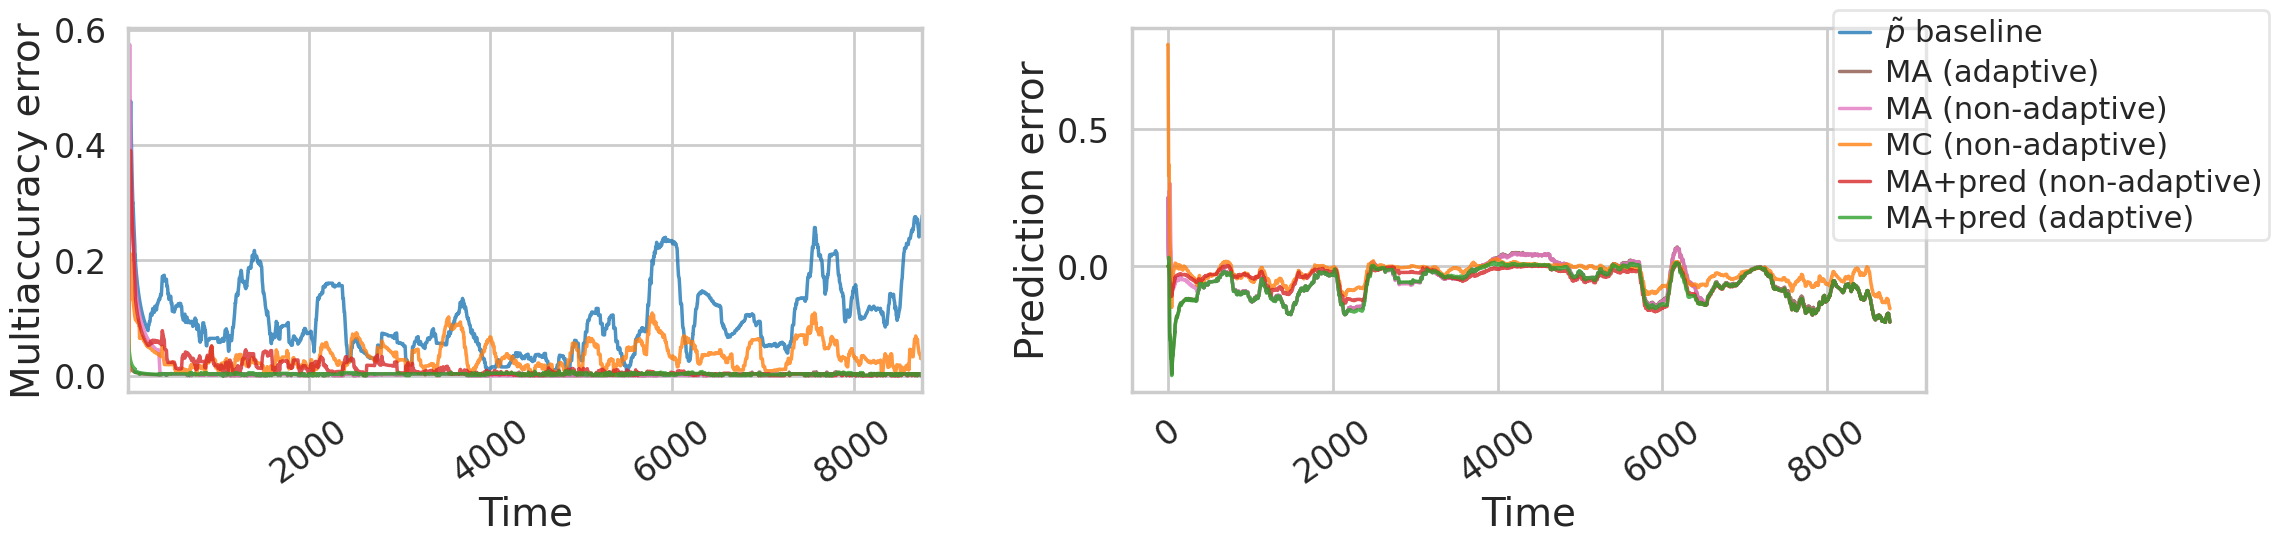

In [14]:
from collections import OrderedDict

series_to_plot = [
    (ptilde_baseline_ma_linf,    r"$\tilde{p}$ baseline",   "ptilde"),
    (maonly_baseline_ma_linf,    r"MA (adaptive)",          "ma"),
    (maonly_nonadaptive_ma_linf, r"MA (non-adaptive)",      "maonly_na"),
    (mc_ma_linf,                 r"MC (non-adaptive)",      "mc_na"),
    (mapred_nonadaptive_ma_linf, r"MA+pred (non-adaptive)", "mapred_na"),
    (mapred_ma_linf,             r"MA+pred (adaptive)",     "mapred"),
]

pred_series_to_plot = [
    (maonly_baseline_lpred,     r"MA (adaptive)",          "ma"),
    (maonly_nonadaptive_lpred,  r"MA (non-adaptive)",      "maonly_na"),
    (mc_lpred,                  r"MC (non-adaptive)",      "mc_na"),
    (mapred_nonadaptive_l_pred, r"MA+pred (non-adaptive)", "mapred_na"),
    (mapred_lpred,              r"MA+pred (adaptive)",     "mapred"),
]

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)  
ax_ma, ax_reg = axes

LEFT_SKIP = 10
T_left = max(len(y) for y, _, _ in series_to_plot if y is not None)
x_left = np.arange(T_left)[LEFT_SKIP:]

# Left plot: multiaccuracy error
for y, label, group in series_to_plot:
    if y is None: 
        continue
    yy = np.asarray(y)
    ax_ma.plot(x_left, yy[LEFT_SKIP:], label=label,
               color=color_dict.get(group, "0.3"),
               linewidth=2.5, alpha=0.8)

ax_ma.set_xlim(x_left[0], x_left[-1])
ax_ma.set_xlabel("Time"); ax_ma.set_ylabel("Multiaccuracy error")
ax_ma.tick_params(axis="x", rotation=35); ax_ma.grid(True)

# Right plot: prediction error
for y, label, group in pred_series_to_plot:
    if y is None: 
        continue
    ax_reg.plot(y, label=label, color=color_dict.get(group, "0.3"),
                linewidth=2.5, alpha=0.8)
ax_reg.set_xlabel("Time"); ax_reg.set_ylabel("Prediction error")
ax_reg.tick_params(axis="x", rotation=35); ax_reg.grid(True)

# Legend on the far right
fig.subplots_adjust(right=0.92, wspace=0.28)
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
by_label = OrderedDict((l, h) for h, l in zip(handles, labels))

fig.legend(
    by_label.values(), by_label.keys(),
    loc="center left", bbox_to_anchor=(0.925, 0.75),  # tight to the edge
    ncol=1,
    frameon=True, framealpha=0.5,
    fontsize=22,                
    handlelength=1.0,          # shorter line samples
    handletextpad=0.5,         # tighter gap line↔text
    borderpad=0.2,             # tighter legend padding
    labelspacing=0.25,         # tighter row spacing
    columnspacing=0.7          
)

plt.tight_layout()
fig.savefig(os.path.join(plots_dir, "ma_and_pred_evaluation.pdf"), bbox_inches="tight")
plt.show()